In [124]:
import logging
import pandas as pd
import os
from pytorch_lightning.plugins.training_type import DDPPlugin
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_galaxy_datasets.galaxy_datamodule import GalaxyDataModule
from zoobot.pytorch.training import losses
from zoobot.pytorch.estimators import define_model
from zoobot.pytorch.estimators import efficientnet_standard, resnet_torchvision_custom  # also resnet_detectron2_custom, imported below
import sys
sys.path.insert(0,'/home/patrikas_v/to_zip/AstroAugmentations/astroaugmentations/')
import image_domain
sys.path.insert(0,'home/patrikas_v/to_zip/zoobot')
from zoobot.shared import label_metadata, schemas
from pytorch_lightning.loggers import WandbLogger
import torch
from pytorch_galaxy_datasets.prepared_datasets import (
    DecalsDR5Dataset,
    decals_dr5_setup,
    GZ2Dataset,
    gz2_setup
)
from pytorch_galaxy_datasets.galaxy_dataset import GalaxyDataset
from zoobot.pytorch.training import train_with_pytorch_lightning
from PIL import Image
from simplejpeg import decode_jpeg
import sys
from typing import Optional
import logging
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pytorch_galaxy_datasets import galaxy_dataset
sys.path.insert(0,'/home/patrikas_v/to_zip/AstroAugmentations')
import astroaugmentations as AA
from astroaugmentations.datasets.galaxy_mnist import GalaxyMNIST
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import simplejpeg
import torch
import os
import logging
import numpy as np
import pandas as pd
train_catalog, train_label_cols = decals_dr5_setup(
    root='/home/patrikas_v/to_zip/decals',  
    train=True,
    download=False
)
val_catalog, test_label_cols = decals_dr5_setup(
    root='/home/patrikas_v/to_zip/decals', 
    train=False,
    download=False
)
def get_img(index):
    galaxy = train_catalog.iloc[index]
    with open(galaxy['file_loc'], 'rb') as f:
        image = Image.fromarray(decode_jpeg(f.read()))
        return image
def display_2imgs(image1, image2):
    display(Image.fromarray(np.hstack((np.array(image1),np.array(image2)))))
def plt_display_two(one, two):
    fig, axes = plt.subplots(1, 2, figsize=(20,10))
    for ax, img in zip(axes, [one, two]):
            ax.imshow(img)
def get_index(): return np.random.randint(0, len(train_catalog))
resize=[A.LongestMaxSize(max_size = 100)]
def perform_on_res(augmentation,image):
     augmentation = (A.Compose(resize + [augmentation]))
     return Image.fromarray(augmentation(image=np.array(image))['image'])
def a(augmentation, plt=1):
    original = get_img(get_index())
    augmented = perform_on_res(augmentation, original)
    original = Image.fromarray(A.Compose(resize)(image=np.array(original))['image'])
    if plt: plt_display_two(original, augmented)
    else: display_2imgs(original, augmented)
    return original, augmented


(<PIL.Image.Image image mode=RGB size=100x100 at 0x7F2D90F4BC10>,
 <PIL.Image.Image image mode=RGB size=100x100 at 0x7F2D7A916F70>)

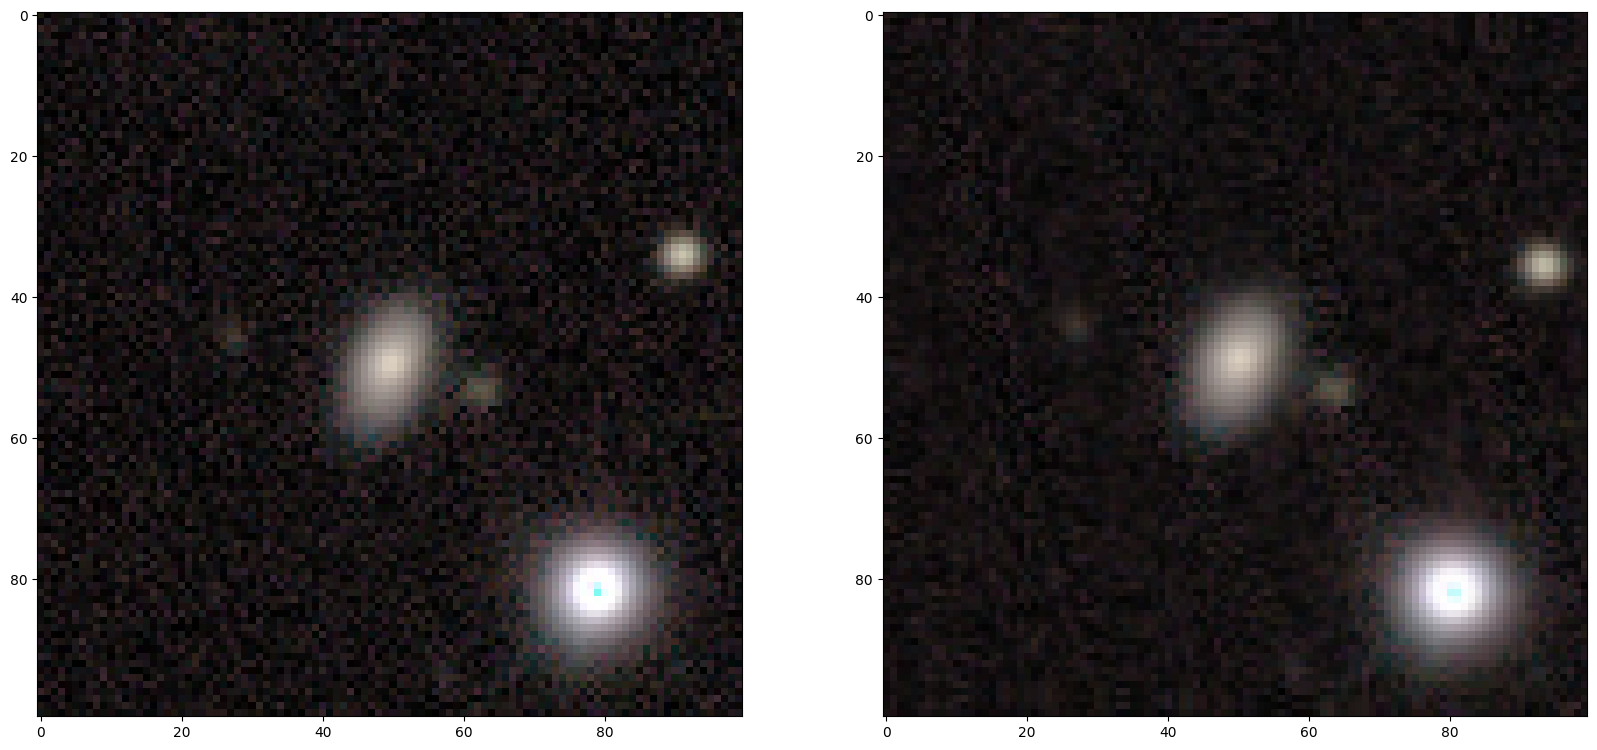

In [125]:
augmentation = A.ElasticTransform(
        alpha=1,
        sigma=100,
        alpha_affine=2)

a(augmentation, plt=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


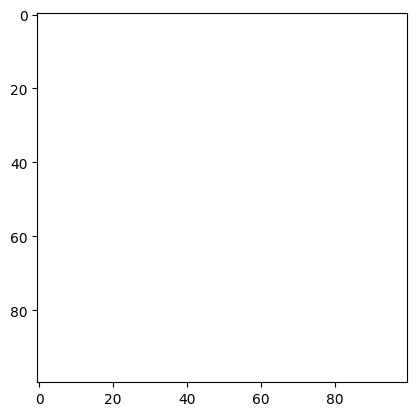

In [130]:
augmentation = A.Lambda(
    name='AddSersicSources', #doesn't work on BW
    image=image_domain.optical.SuperimposeSources(
        mode='sersic',
        max_number=1,
        extent=(0, 1),
        scaling='default'
    )
)

plt.imshow((A.Compose(augmentation)(image=np.array(img)))['image'])

# a(augmentation, plt=0)

# Image.fromarray((A.Compose(augmentation)(image=np.array(img)))['image'])

In [8]:
A.Lambda( # doesn't work on BW
    name='AddGaussianSources',
    image=image_domain.optical.SuperimposeSources(
        mode='gaussian',
        max_number=1,
        extent=(self.gaussian_extent_min_datamodule, self.gaussian_extent_max_datamodule),
        scaling=None
    )
)

AttributeError: 'Image' object has no attribute 'shape'

In [ ]:
                A.Lambda(
                    name="Brightness perspective distortion", 
                    image=image_domain.BrightnessGradient(
                        limits=[self.brightness_gradient_minimum_datamodule, 1],
                        noise = self.brightness_gradient_noise_datamodule),
                    p=self.p_brightness_gradient_datamodule
                ),

In [ ]:
                A.ShiftScaleRotate(
                    shift_limit=self.album_shift_limit_datamodule, scale_limit=self.album_scale_limit_datamodule,
                    rotate_limit=self.album_rotate_limit_datamodule, interpolation=2,
                    border_mode=0,
                p=self.p_album_shiftscalerotate_datamodule),

In [ ]:
                A.Flip(p=self.p_flip_datamodule),

In [ ]:
                A.Lambda(
                    name="MissingData",
                    image=image_domain.optical.ChannelWiseDropout(
                        max_fraction=self.channelwisedropout_max_fraction_datamodule,
                        min_width=self.channelwisedropout_min_width_datamodule,
                        min_height=self.channelwisedropout_min_height_datamodule,
                        max_holes=self.channelwisedropout_max_holes_datamodule,
                        channelwise_application=True,
                    ),
                    p=self.p_channelwisedropout_datamodule
                ),